In [1]:
!nvidia-smi -L

GPU 0: NVIDIA A100-PCIE-40GB (UUID: GPU-3fac7503-bb55-35cd-f566-c919eaa55798)
GPU 1: NVIDIA A100-PCIE-40GB (UUID: GPU-bf03abcd-ef36-6733-da57-460c8eb9cab4)
GPU 2: NVIDIA A100-PCIE-40GB (UUID: GPU-bc01f8f3-0939-f2c0-6998-dd49d0360463)
GPU 3: NVIDIA A100-PCIE-40GB (UUID: GPU-b7aeac00-b332-1045-eebc-bb5653ac8402)


In [2]:
# Add the fourier_learning_ibm package to the path
# This is necessary only when running the notebook in the docker container
import sys, pprint

sys.path.append("/home/jovyan/fourier_learning_ibm/")
pprint.pprint(sys.path)

# This is necessary only when running the notebook in the docker container
%cd fourier_learning_ibm/

['/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/home/jovyan/fourier_learning_ibm/']
/root/workdir/fourier_learning_ibm


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
from qiskit import *
from qiskit.circuit.library import *
from qiskit.circuit.random import random_circuit
from qiskit_aer import *
from qiskit_ibm_runtime import SamplerV2 as Sampler, Batch
from setup import setup_backend

from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import SuzukiTrotter

from qiskit.circuit import Parameter
from qiskit.quantum_info import Pauli, SparsePauliOp
import numpy as np

In [ ]:
# density matrix simulator
backend_qpu, backend_dm_noiseless, backend_dm_noisy = setup_backend(
    qpu_name="ibm_marrakesh", device="GPU", method="density_matrix"
)

# matrix product state simulator
backend_qpu, backend_mps_noiseless, backend_mps_noisy = setup_backend(
    qpu_name="ibm_marrakesh", device="GPU", method="matrix_product_state"
)

Using backend QPU: <IBMBackend('ibm_marrakesh')>

NoiseModel:
  Basis gates: ['cz', 'delay', 'for_loop', 'id', 'if_else', 'measure', 'reset', 'rz', 'switch_case', 'sx', 'x']
  Instructions with noise: ['sx', 'x', 'reset', 'measure', 'cz', 'id']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155]
  Specific qubit errors: [('sx', (0,)), ('sx', (1,)), ('sx', (2

In [ ]:
J = Parameter("J")
h = Parameter("h")

qubits = 52
pauli_list = []
coeffs = []
for i in range(qubits - 1):
    x_p = np.zeros(qubits, dtype=bool)
    z_p = np.zeros(qubits, dtype=bool)
    z_p[i] = True
    z_p[i + 1] = True
    pauli_list.append(Pauli((z_p, x_p)))
    coeffs.append(-J)

for i in range(qubits):
    x_p = np.zeros(qubits, dtype=bool)
    z_p = np.zeros(qubits, dtype=bool)
    x_p[i] = True
    pauli_list.append(Pauli((z_p, x_p)))
    coeffs.append(h)

H = SparsePauliOp(pauli_list, coeffs=coeffs)

# assign J & h values:
H = H.assign_parameters({J: 1, h: 1})

In [ ]:
gate = PauliEvolutionGate(H)

st = SuzukiTrotter(order=2, reps=1)
circ = st.synthesize(gate)
circ.measure_all()
# circ.draw('mpl')
circ = transpile(circ, backend_mps_noisy)

In [ ]:
# bond dimension = 100
sim = backend_mps_noisy
shots = 1000

with Batch(backend=sim) as batch:
    sampler = Sampler(mode=batch)
    job = sampler.run([circ], shots=shots)

result = job.result()

print(result[0].data.meas.get_counts())

{'0111111110110111011010011101001101100111011011111111': 1, '1011111111011110100110111001110011011011011111100101': 1, '0111111101011110110010111001111111000000111110101111': 1, '1110010101110110111111110101001100111110111110110110': 1, '1101011111111111010110101101100001100111010111101101': 1, '1111110111111110111010110101101010101111101010110101': 1, '1001011010101111100110000101111101010111111010010010': 1, '0101111100110111101101011101110011010110010100111110': 1, '0101010111011101111011110001111111010110011111011111': 1, '0001011011111111110001110011000111101111111101111101': 1, '0011100111110111110010111110111011111110111111101011': 1, '0110101101101001110111010100100011111011111111100111': 1, '1011101000010100110011111011011110011101111111100110': 1, '1101111101000111111100110001011110101110011101111110': 1, '1111100110011111010101111011110111111111011001110110': 1, '1111101111111001111100011101010101011111111011111010': 1, '0011101010111010101111001000101101110111110011111111':

In [ ]:
# bond dimension = 50
sim = backend_mps_noisy
shots = 1000

with Batch(backend=sim) as batch:
    sampler = Sampler(mode=batch)
    job = sampler.run([circ], shots=shots)

result = job.result()

print(result[0].data.meas.get_counts())

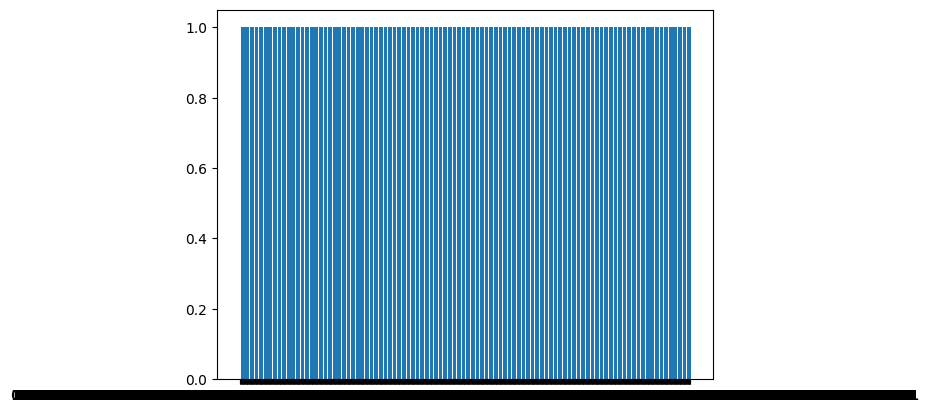

In [10]:
# Plot
import matplotlib.pyplot as plt

plt.bar(
    result[0].data.meas.get_counts().keys(), result[0].data.meas.get_counts().values()
)
plt.show()

In [4]:
import cupy as cp
import time

In [5]:
# 行列のサイズを定義
N = 2**15

start = time.time()
with cp.cuda.Device(0):
    for i in range(10):
        # CuPy を使ってランダムな行列を生成
        A = cp.random.rand(N, N, dtype=cp.float64)
        B = cp.random.rand(N, N, dtype=cp.float64)

        if i == 0:
            # 行列のデータサイズを確認
            print(
                "行列 A のデータサイズ: {:.2f} B = {:.2f} GB".format(
                    A.nbytes, A.nbytes / 1024**3
                )
            )
            print(
                "行列 B のデータサイズ: {:.2f} B = {:.2f} GB".format(
                    B.nbytes, B.nbytes / 1024**3
                )
            )

        C = cp.dot(A, B)
        end = time.time()

        del A, B, C
        cp.get_default_memory_pool().free_all_blocks()
        cp.get_default_pinned_memory_pool().free_all_blocks()

end = time.time()
print("行列積の計算時間: {:.4f}秒".format(end - start))

CUDARuntimeError: cudaErrorNoDevice: no CUDA-capable device is detected

In [1]:
import cupy as cp
import time

# random な疎行列を作成し、その行列積を計算する。計算は cupy で行う
import scipy.sparse
import cupyx.scipy.sparse

# 疎行列のサイズを定義
N = 2**14
density = 0.01

start = time.time()
with cp.cuda.Device(0):
    for i in range(10):
        # CuPy を使ってランダムな疎行列を生成
        A = cupyx.scipy.sparse.random(
            N, N, density=density, format="csr", dtype=cp.float64
        )
        B = cupyx.scipy.sparse.random(
            N, N, density=density, format="csr", dtype=cp.float64
        )

        if i == 0:
            # 疎行列のデータサイズを確認
            print(
                "行列 A のデータサイズ: {:.2f} B = {:.2f} GB".format(
                    A.data.nbytes, A.data.nbytes / 1024**3
                )
            )
            print(
                "行列 B のデータサイズ: {:.2f} B = {:.2f} GB".format(
                    B.data.nbytes, B.data.nbytes / 1024**3
                )
            )

        C = A.dot(B)
        end = time.time()

        del A, B, C
        cp.get_default_memory_pool().free_all_blocks()
        cp.get_default_pinned_memory_pool().free_all_blocks()

行列 A のデータサイズ: 21474832.00 B = 0.02 GB
行列 B のデータサイズ: 21474832.00 B = 0.02 GB
